In [1]:
  # 1. Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# 2. Imports
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os


In [4]:
# 3. Paths & Parameters
IMG_SIZE = 224
BATCH_SIZE = 16
INITIAL_EPOCHS = 3
FINE_TUNE_EPOCHS = 2

train_dir = "/content/drive/MyDrive/Trim_dataset/Trim_dataset/Dataset/Train"
val_dir = "/content/drive/MyDrive/Trim_dataset/Trim_dataset/Dataset/Validation"
test_dir = "/content/drive/MyDrive/Trim_dataset/Trim_dataset/Dataset/Test"
model_path = "/content/drive/MyDrive/vgg19_best_model.h5"


In [5]:
# 4. Data Generators
train_aug = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.2,
    zoom_range=0.3,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    fill_mode='nearest'
)

val_aug = ImageDataGenerator(rescale=1./255)
test_aug = ImageDataGenerator(rescale=1./255)

train_gen = train_aug.flow_from_directory(train_dir, target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode='binary')
val_gen = val_aug.flow_from_directory(val_dir, target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode='binary')
test_gen = test_aug.flow_from_directory(test_dir, target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode='binary', shuffle=False)


Found 1751 images belonging to 2 classes.
Found 1315 images belonging to 2 classes.
Found 1728 images belonging to 2 classes.


In [6]:
# 5. VGG19 Model Setup
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
for layer in base_model.layers:
    layer.trainable = False

x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [7]:
# 6. Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint(model_path, monitor='val_accuracy', save_best_only=True, verbose=1)
callbacks = [early_stop, checkpoint]


In [9]:
# 7. Initial Training
history = model.fit(train_gen, validation_data=val_gen, epochs=INITIAL_EPOCHS, callbacks=callbacks, verbose=1)

# Print per-epoch stats
for i in range(INITIAL_EPOCHS):
    print(f"Epoch {i+1}/{INITIAL_EPOCHS}")
    print(f" - Train Loss: {history.history['loss'][i]:.4f} | Train Acc: {history.history['accuracy'][i]*100:.2f}%")
    print(f" - Val Loss:   {history.history['val_loss'][i]:.4f} | Val Acc:   {history.history['val_accuracy'][i]*100:.2f}%\n")


Epoch 1/3
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.6590 - loss: 0.6255 
Epoch 1: val_accuracy improved from -inf to 0.79620, saving model to /content/drive/MyDrive/vgg19_best_model.h5


110/110 ━━━━━━━━━━━━━━━━━━━━ 2428s 22s/step - accuracy: 0.6590 - loss: 0.6255 - val_accuracy: 0.7962 - val_loss: 0.5105
Epoch 2/3
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.6997 - loss: 0.5971 
Epoch 2: val_accuracy improved from 0.79620 to 0.87529, saving model to /content/drive/MyDrive/vgg19_best_model.h5


110/110 ━━━━━━━━━━━━━━━━━━━━ 2369s 22s/step - accuracy: 0.6998 - loss: 0.5970 - val_accuracy: 0.8753 - val_loss: 0.3457
Epoch 3/3
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.7187 - loss: 0.5629 
Epoch 3: val_accuracy did not improve from 0.87529
110/110 ━━━━━━━━━━━━━━━━━━━━ 2362s 22s/step - accuracy: 0.7187 - loss: 0.5628 - val_accuracy: 0.8532 - val_loss: 0.4122
Epoch 1/3
 - Train Loss: 0.6246 | Train Acc: 65.85%
 - Val Loss:   0.5105 | Val Acc:   79.62%

Epoch 2/3
 - Train Loss: 0.5899 | Train Acc: 70.30%
 - Val Loss:   0.3457 | Val Acc:   87.53%

Epoch 3/3
 - Train Loss: 0.5605 | Train Acc: 71.73%
 - Val Loss:   0.4122 | Val Acc:   85.32%



In [12]:
# 8. Fine-Tuning Last Layers
for layer in base_model.layers[-8:]:
    layer.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='binary_crossentropy', metrics=['accuracy'])

history_fine = model.fit(train_gen, validation_data=val_gen, epochs=FINE_TUNE_EPOCHS, callbacks=callbacks, verbose=1)

for i in range(FINE_TUNE_EPOCHS):
    print(f"Fine-Tune Epoch {i+1}/{FINE_TUNE_EPOCHS}")
    print(f" - Train Loss: {history_fine.history['loss'][i]:.4f} | Train Acc: {history_fine.history['accuracy'][i]*100:.2f}%")
    print(f" - Val Loss:   {history_fine.history['val_loss'][i]:.4f} | Val Acc:   {history_fine.history['val_accuracy'][i]*100:.2f}%\n")


Epoch 1/2
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 20s/step - accuracy: 0.8410 - loss: 0.3872 
Epoch 1: val_accuracy did not improve from 0.87529
110/110 ━━━━━━━━━━━━━━━━━━━━ 3189s 29s/step - accuracy: 0.8409 - loss: 0.3873 - val_accuracy: 0.8510 - val_loss: 0.3290
Epoch 2/2
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 20s/step - accuracy: 0.8605 - loss: 0.3490 
Epoch 2: val_accuracy improved from 0.87529 to 0.88517, saving model to /content/drive/MyDrive/vgg19_best_model.h5


110/110 ━━━━━━━━━━━━━━━━━━━━ 3170s 29s/step - accuracy: 0.8605 - loss: 0.3489 - val_accuracy: 0.8852 - val_loss: 0.2920
Fine-Tune Epoch 1/2
 - Train Loss: 0.3949 | Train Acc: 83.61%
 - Val Loss:   0.3290 | Val Acc:   85.10%

Fine-Tune Epoch 2/2
 - Train Loss: 0.3403 | Train Acc: 86.64%
 - Val Loss:   0.2920 | Val Acc:   88.52%



108/108 ━━━━━━━━━━━━━━━━━━━━ 1345s 12s/step


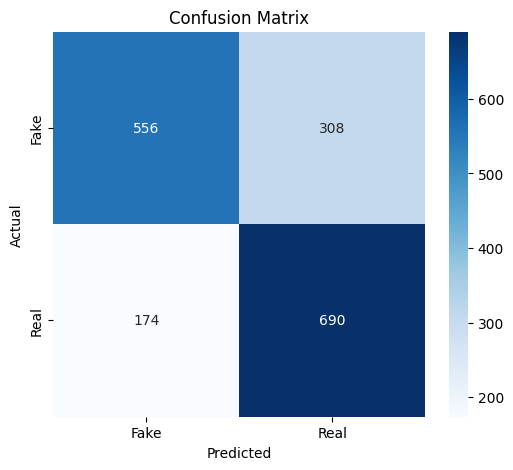

Classification Report:
              precision    recall  f1-score   support

        Fake       0.76      0.64      0.70       864
        Real       0.69      0.80      0.74       864

    accuracy                           0.72      1728
   macro avg       0.73      0.72      0.72      1728
weighted avg       0.73      0.72      0.72      1728


✅ Final Test Accuracy: 72.11%


In [13]:
# 9. Evaluate on Test Set
model.load_weights(model_path)
test_gen.reset()
preds = model.predict(test_gen)
y_pred = np.round(preds).astype(int).flatten()
y_true = test_gen.classes
labels = list(test_gen.class_indices.keys())

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=labels))

# Final Accuracy
final_accuracy = accuracy_score(y_true, y_pred)
print(f"\n✅ Final Test Accuracy: {final_accuracy * 100:.2f}%")


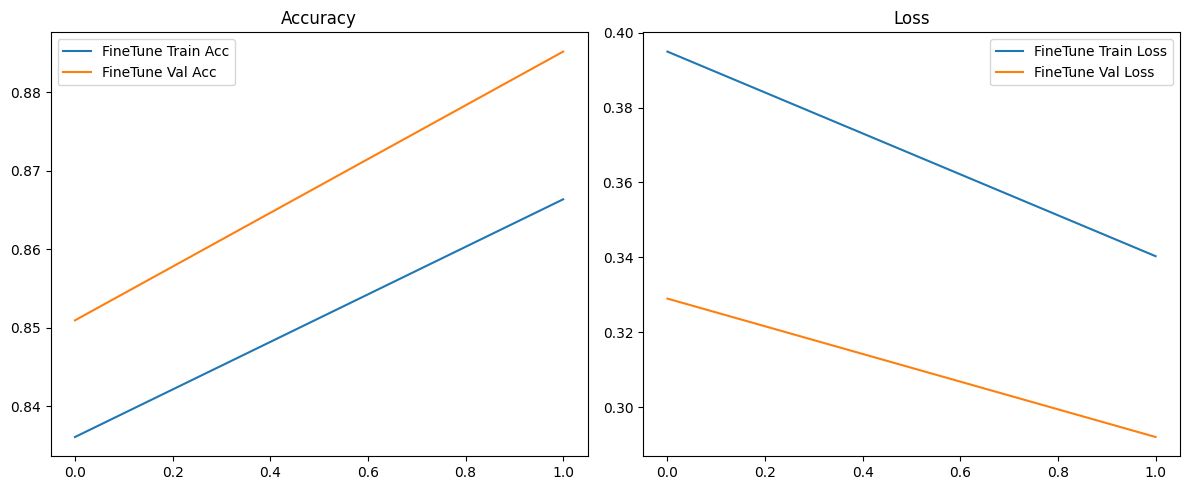

In [23]:
# 10. Accuracy & Loss Graphs
def plot_metrics(history, label):
    plt.plot(history.history['accuracy'], label=f'{label} Train Acc')
    plt.plot(history.history['val_accuracy'], label=f'{label} Val Acc')

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)

plot_metrics(history_fine, "FineTune")
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)

plt.plot(history_fine.history['loss'], label='FineTune Train Loss')
plt.plot(history_fine.history['val_loss'], label='FineTune Val Loss')
plt.title('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [15]:
# 11. Save Predictions to CSV
filenames = test_gen.filenames
results_df = pd.DataFrame({
    'Filename': filenames,
    'True Label': y_true,
    'Predicted Label': y_pred,
    'Confidence': preds.flatten()
})
results_df.to_csv('/content/drive/MyDrive/vgg19_test_results.csv', index=False)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 862ms/step


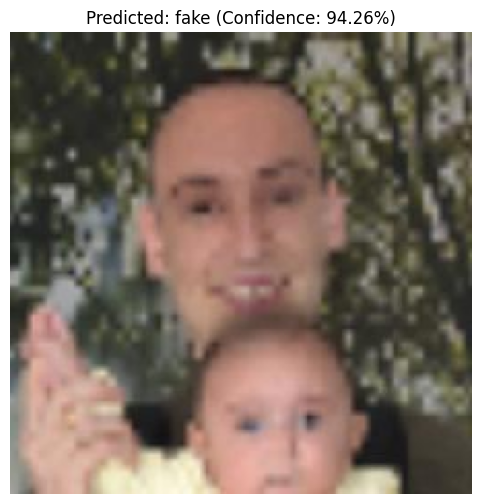

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 668ms/step


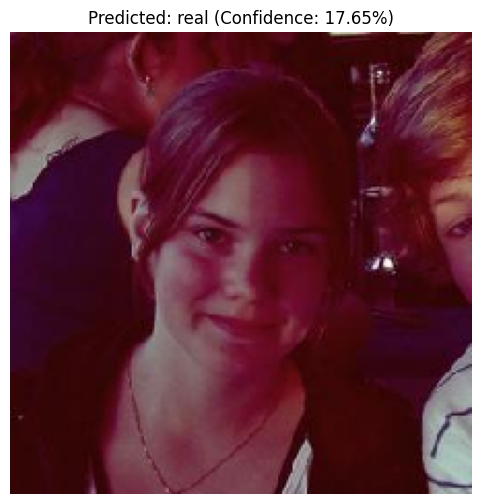

In [21]:
# Import necessary libraries
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Set image size used in your model
IMG_SIZE = 224  # Adjust this if your model used a different size

# Load your trained model (make sure it's already trained and saved)
model_path = "/content/drive/MyDrive/vgg19_best_model.h5"
model = tf.keras.models.load_model(model_path)

# Function to load, preprocess, and predict
def load_and_predict(img_path):
    img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    img_array = image.img_to_array(img) / 255.0  # Normalize the image
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    prediction = model.predict(img_array)
    predicted_class = 'real' if prediction[0] < 0.5 else 'fake'
    return img, predicted_class, prediction[0]

# List of test image paths (update with your image paths)
test_image_paths = [
    "/content/drive/MyDrive/Trim_dataset/Trim_dataset/Dataset/Test/Fake/fake_102.jpg",
    "/content/drive/MyDrive/Trim_dataset/Trim_dataset/Dataset/Test/Real/real_0.jpg"
]

# Display each image and its prediction with confidence in percentage
for img_path in test_image_paths:
    img, predicted_class, confidence = load_and_predict(img_path)

    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_class} (Confidence: {confidence.item() * 100:.2f}%)")
    plt.axis('off')
    plt.show()
